# ML to find radial velocities using FIRE data

In [2]:
%matplotlib inline

import matplotlib
import matplotlib.colors as colors

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path
import sys
import gzip
import matplotlib.gridspec as gridspec

matplotlib.rcParams.update({'font.family':'cmr10','font.size': 13})
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams['axes.labelsize']=15
plt.rcParams['figure.figsize']=(4,4)
plt.rcParams['figure.dpi'] = 80
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

In [3]:
data = np.load('StarsWithRadialVelocity.npy')

In [4]:
data_cols = ['l', 'b','ra', 'dec', 'pmra', 'pmdec', 'parallax', 'radial_velocity',
             'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag',
             'pmra_error', 'pmdec_error', 'parallax_error', 'radial_velocity_error',
             'phot_g_mean_mag_error', 'phot_bp_mean_mag_error', 'phot_rp_mean_mag_error',
             'AccretedLabel'
            ]
#could train on radial_velocity_error

In [5]:
data = pd.DataFrame(data, columns=data_cols)

In [6]:
data.shape

(11400846, 19)

In [7]:
data.head()


,l,b,ra,dec,pmra,pmdec,parallax,radial_velocity,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,pmra_error,pmdec_error,parallax_error,radial_velocity_error,phot_g_mean_mag_error,phot_bp_mean_mag_error,phot_rp_mean_mag_error,AccretedLabel
0,18.947771,17.087326,261.281075,-4.105546,0.304014,-2.012651,0.443537,44.472788,14.384683,14.678857,13.931516,0.091557,0.091557,0.044116,9.908263,0.000611,0.003929,0.003929,0.0
1,-4.978819,-41.542610,315.656827,-45.372252,15.768343,-16.975898,1.369992,-120.045033,12.405884,12.633657,12.030871,0.087001,0.087001,0.042780,2.036502,0.000342,0.002105,0.002105,0.0
2,-137.539419,-47.311996,60.814237,-25.789371,5.542696,9.388474,0.597262,83.063864,14.347357,14.619976,13.923520,0.091365,0.091365,0.044055,9.917098,0.000602,0.003861,0.003861,0.0
3,-68.315598,-32.353069,71.998054,-78.933526,14.320530,-13.669455,0.862436,-106.062495,14.062039,14.311761,13.648176,0.090130,0.090130,0.043668,7.792049,0.000544,0.003407,0.003407,0.0
4,85.879721,-52.988838,351.547535,3.638489,2.937268,5.109022,1.510236,-23.143291,14.677980,15.082906,14.107460,0.093275,0.093275,0.044678,11.110764,0.000683,0.004529,0.004529,0.0


In [8]:
#data = data.drop(data[data.AccretedLabel > 0.0].index)

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.interpolate import interp1d

Removed 62,035 stars labeled as accreted. 

In [10]:
#data = data.drop(data[data.radial_velocity > 100.0].index)

Removed 484569 stars with radial velocity greater than 100. 

In [11]:
#data = data.drop(data[data.radial_velocity < -100.0].index)

In [12]:
# What columns to use?
use_cols = ['l', 'b','parallax','pmra','pmdec']
# Make the design matrix
X = data[use_cols].values
Y = (data['radial_velocity']).values
#Y = (Y - np.mean(Y))/(np.std(Y))

In [13]:
print(X.shape)
print(Y.shape)

(11400846, 5)
(11400846,)


I think this is giving me a negative output because it's summing over y_train, which is not the number of stars, but is instead the radial velocities. 

In [14]:
x_train, X_test, Y_train, y_test = train_test_split(X[1:50001], Y[1:50001],
                                                    test_size = 0.2,
                                                    random_state=42)

In [15]:
SS = StandardScaler()
x_train = SS.fit_transform(x_train)
# Now scale the test data using the same mean and standard deviation as found with the training data
X_test = SS.transform(X_test)

Y_train = Y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
#SS_rv = StandardScaler()
#Y_train = SS_rv.fit_transform(Y_train.reshape(-1, 1))
#y_test = SS_rv.transform(y_test.reshape(-1, 1))

In [16]:
X_train = x_train[1:32000,:]
y_train = Y_train[1:32000]
X_val = x_train[32001:40000,:]
y_val = Y_train[32001:40000]
#need to split for validation
y_low = -700
y_high = 700

In [17]:
print(X_train.shape)
print(y_train.shape)
print('There are {0} stars in the training set'.format(np.sum(y_train)))
print()
print(X_test.shape)
print(y_test.shape)
print('There are {0} stars in the test set'.format(np.sum(y_test)))
print(X_val.shape)
print(y_val.shape)

(31999, 5)
(31999, 1)
There are -136551.90202454577 stars in the training set

(10000, 5)
(10000, 1)
There are -42238.39870657218 stars in the test set
(7999, 5)
(7999, 1)


In [18]:
#trying to add some weights to training data
#might weight the mean, but no weights on confidence model? (something to think about)
vr_real = Y_train
counts, bins = np.histogram(vr_real,bins=np.linspace(-700,700,51))
bin_centers = (bins[1:]+bins[:-1])/2
interp_func  = interp1d(bin_centers,(counts).astype('float'))
inv_weights = interp_func(vr_real)
weights = 1/inv_weights
weights = np.log(weights)
weights = weights - np.min(weights)

weights_train = weights[1:32000]
weights_val = weights[32001:40000]

#visualize check data
for i, col in enumerate(use_cols):
    plt.figure(figsize=(6, 3))
    plt.subplot(1,2,1)
    plt.hist(data[col], bins=100)
    plt.yscale('log')
    plt.title('Data')
    
    plt.subplot(1,2,2)
    plt.hist(X_train[:, i], bins=100, alpha=0.5)
    plt.hist(X_test[:, i], bins=100, alpha=0.5)
    plt.yscale('log')
    plt.title('Scaled')
    
    plt.suptitle(col, y=1.01, fontsize=16)
    
    plt.tight_layout()

In [19]:
print(np.max(y_train))

578.7826559777789


In [20]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

Using TensorFlow backend.


In [21]:
from keras import backend as K
from keras import callbacks as callbacks
global index 

In [22]:
class PlotErrors_Mean(callbacks.callbacks.Callback):
    def on_train_begin(self,logs = {}):
        self.i = 0
        self.train_data = [X_train, y_train]
        self.targets = []  # collect y_true batches
        self.outputs = []
        
        self.fig = plt.figure()
    def on_epoch_end(self, epoch, logs={}):
        self.i += 1
        if self.i % 10 == 0:
            #what happens during each epoch
            x_train, y_train = self.train_data
            self.targets = y_train
            prediction = self.model.predict(x_train)
            self.outputs = prediction

            clear_output(wait=True)
            
            hb = plt.hexbin(self.targets, self.outputs[:,0],gridsize=75)
            clb = plt.colorbar(hb,label = 'Absolute Error Epoch '+str(self.i))
            plt.clim(0,100)
            
            #sc = plt.scatter(self.targets, self.outputs[:,0], c =self.outputs[:,1], label = 'epoch '+str(self.i),marker = '.',cmap=plt.cm.YlOrRd,markeredgewidth=1.5,markeredgecolor='k')
            x1 = np.linspace(y_low,y_high,1000)
            y1 = x1
            plt.plot(x1,y1,'k--')
            plt.xlim([y_low, y_high])
            plt.ylim([y_low, y_high])
            #clb = plt.colorbar(sc,label = 'Absolute Error Epoch '+str(self.i))
            #plt.clim(0,y_high/2)
            plt.ylabel('Vr predicted')
            plt.xlabel('Vr real')
            #legend = plt.legend()
            #plt.show();
            plt.savefig('error_images/error_epoch_'+str(self.i)+'.png')
            clb.remove()
            #legend.remove()
        
plot_errors_mean = PlotErrors_Mean()

For now, hold off on training PlotErrors_Conf, until can tell what epoch Mean stops on.

In [23]:
class PlotErrors_Conf(callbacks.callbacks.Callback):
    def on_train_begin(self,logs = {}):
        self.i = 1000
        self.train_data = [X_train, y_train]
        #what happens when training begins, initializations
        self.targets = []  # collect y_true batches
        self.outputs = []
        
        self.fig = plt.figure()
        #sc = plt.scatter(X_train[:,1], y_train, c =y_train, label = 'epoch '+str(self.i),marker = '.',cmap=plt.cm.YlOrRd)
        #plt.colorbar(sc, label = 'Absolute Error')
        #plt.clim(0,3)
    def on_epoch_end(self, epoch, logs={}):
        self.i += 1
        if self.i % 10 == 0:
            #what happens during each epoch
            x_train, y_train = self.train_data
            self.targets = y_train
            prediction = self.model.predict(x_train)
            self.outputs = prediction

            clear_output(wait=True)
            #plt.scatter(self.targets, self.outputs[:,0],color = 'blue', label = 'epoch '+str(self.i))
            #plt.errorbar(self.targets, self.outputs[:,0], yerr = self.outputs[:,1], color = 'red', ls = 'none')
            sc = plt.scatter(self.targets, self.outputs[:,0], c =self.outputs[:,1], label = 'epoch '+str(self.i),marker = '.',cmap=plt.cm.YlOrRd)
            x1 = np.linspace(y_low,y_high,1000)
            y1 = x1
            plt.plot(x1,y1,'k--')
            plt.xlim([y_low, y_high])
            plt.ylim([y_low, y_high])
            clb = plt.colorbar(sc,label = 'Absolute Error Epoch '+str(self.i))
            plt.clim(0,y_high/2)
            plt.ylabel('Vr predicted')
            plt.xlabel('Vr real')
            #legend = plt.legend()
            #plt.show();
            plt.savefig('error_images/error_epoch_'+str(self.i)+'.png')
            clb.remove()
            #legend.remove()
        
plot_errors_conf = PlotErrors_Conf()

In [24]:
def LikelihoodLossFunction(y_true, y_pred):
    # shape of y_pred should be (nsamples, 2)
    # the first column should be the mean of the prediction
    # the second column is the confidence (number of standard deviations)
#     print y_true.shape
#     print y_pred.shape
    SIGMA = K.abs(y_pred[:, 1]) + 1e-6
    LOC = y_pred[:, 0]
    X = y_true[:, 0]
    weights = y_true[:,1]
    ARG = K.square(X - LOC) / (2 * K.square(SIGMA))
    PREFACT = K.log(K.pow(2 * np.pi * K.square(SIGMA), -0.5))
    return K.mean((ARG - PREFACT) * weights)


In [25]:
def ConstantLikelihoodLossFunction(y_true, y_pred):
    # shape of y_pred should be (nsamples, 2)
    # the first column should be the mean of the prediction
    # the second column is the confidence (number of standard deviations)
#     print y_true.shape
#     print y_pred.shape
    LOC = y_pred[:, 0]
    X = y_true[:, 0]
    weights = y_true[:,1]
    ARG = K.square(X - LOC) / (2.0)
    PREFACT = K.log(K.pow(2 * np.pi, -0.5))
    return K.mean((ARG - PREFACT) * weights)


# Two network technique to calculate the error

In [26]:
from keras.layers import Input, Dense, Lambda, Concatenate, Dropout
from keras.models import Model
from keras.utils import plot_model
from IPython.display import clear_output
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

In [27]:
y_train = np.hstack([y_train, weights_train])
y_val = np.hstack([y_val, weights_val])

In [28]:
# del(inputs, MeanEst, MeanModel, ConfEst, ConfModel)
inputs = Input(shape=(5,))
MeanEst = (Dense(30, activation='relu'))(inputs)
MeanEst = (Dropout(0.1))(MeanEst)
MeanEst = (Dense(30, activation='relu'))(MeanEst)
MeanEst = (Dropout(0.1))(MeanEst)
MeanEst = (Dense(10, activation='relu'))(MeanEst)
MeanEst = (Dropout(0.1))(MeanEst)
MeanEst = (Dense(10, activation='relu'))(MeanEst)
MeanEst = (Dense(1, activation='linear'))(MeanEst)
MeanModel = Model(inputs=[inputs], outputs=MeanEst)

ConfEst= (Dense(30, activation='relu'))(inputs)
ConfEst = (Dropout(0.1))(ConfEst)
ConfEst= (Dense(30, activation='relu'))(ConfEst)
ConfEst = (Dropout(0.1))(ConfEst)
ConfEst= (Dense(30, activation='relu'))(ConfEst)
ConfEst = (Dropout(0.1))(ConfEst)
ConfEst= (Dense(30, activation='relu'))(ConfEst)
ConfEst= (Dense(1, activation='relu'))(ConfEst)
ConfModel = Model(inputs=[inputs], outputs=ConfEst)
#how can this give me a confidence output? the only thing that appears to define a confidence is the relu
#on the last layer...think about this.
#CombinedSub = Concatenate(axis=-1)([MeanEst, ConfEst])
CombinedSub = Concatenate(axis=-1)([MeanModel(inputs), ConfModel(inputs)])

CombinedModel = Model(inputs=[inputs], outputs=CombinedSub)
#plot_model(CombinedModel,to_file='demo.png',show_shapes=True)

In [29]:
CombinedModel.save_weights('.models/TrainingMean_0000.hdf5')

In [30]:
CombinedModel.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5)            0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1)            1541        input_1[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 1)            3001        input_1[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 2)            0           model_1[1][0]                    
                                                                 model_2[1][0]              

In [31]:
CheckPoint = ModelCheckpoint('models/TrainingMean_{epoch:04d}.hdf5',
                             verbose=0,
                             save_best_only=False
                            )
ES = EarlyStopping(patience=20, verbose=True, restore_best_weights=True)
RLR = ReduceLROnPlateau(patience=10, min_lr=1e-5, verbose=True)
CSV_logger = CSVLogger(filename='logs/training_mean.log', separator=',', append=False)

mycallbacks = [CheckPoint, ES, RLR, CSV_logger]

In [32]:
ConfModel.trainable = False
MeanModel.trainable = True
CombinedModel.compile(loss=ConstantLikelihoodLossFunction,
                      optimizer='adam'
                     )
#why does the loss only return not nan when I use this ...I'm guessing it has to do with the log...
history = CombinedModel.fit(X_train,y_train,
                  validation_data=(X_val, y_val),
                  epochs=1000,
                  batch_size=10000,
                  callbacks = mycallbacks
                 )

Train on 31999 samples, validate on 7999 samples
Epoch 1/1000
31999/31999 [==============================] - 1s 19us/step - loss: 6545.4421 - val_loss: 6411.9922
Epoch 2/1000
31999/31999 [==============================] - 0s 4us/step - loss: 6544.5879 - val_loss: 6411.1230
Epoch 3/1000
31999/31999 [==============================] - 0s 4us/step - loss: 6544.0237 - val_loss: 6410.4614
Epoch 4/1000
31999/31999 [==============================] - 0s 4us/step - loss: 6543.1780 - val_loss: 6409.6558
Epoch 5/1000
31999/31999 [==============================] - 0s 4us/step - loss: 6542.3814 - val_loss: 6408.9614
Epoch 6/1000
31999/31999 [==============================] - 0s 4us/step - loss: 6541.5656 - val_loss: 6408.0005
Epoch 7/1000
31999/31999 [==============================] - 0s 4us/step - loss: 6541.0014 - val_loss: 6406.9917
Epoch 8/1000
31999/31999 [==============================] - 0s 4us/step - loss: 6540.3482 - val_loss: 6405.8438
Epoch 9/1000
31999/31999 [============================

Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.


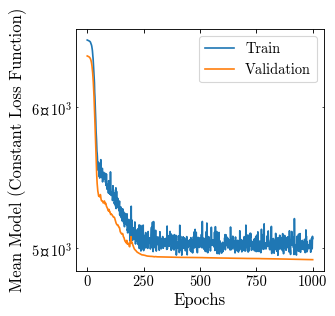

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Mean Model (Constant Loss Function)')
plt.legend(['Train', 'Validation'])
plt.show()

In [35]:
CheckPoint2 = ModelCheckpoint('models/TrainingErrorBars_{epoch:04d}.hdf5',
                             verbose=0,
                             save_best_only=False
                            )
ES2 = EarlyStopping(patience=20, verbose=True, restore_best_weights=True)
RLR2 = ReduceLROnPlateau(patience=10, min_lr=1e-5)
CSV_logger2 = CSVLogger(filename='logs/training_errorbars.log', separator=',', append=False)

mycallbacks2 = [CheckPoint2, ES2, RLR2, CSV_logger2]

In [36]:
ConfModel.trainable = True
MeanModel.trainable = False
CombinedModel.compile(loss=LikelihoodLossFunction,
                      optimizer='adam'
                     )

history = CombinedModel.fit(X_train,y_train,
                  validation_data=(X_val, y_val),
                  epochs=1000,
                  batch_size=10000,
                  callbacks = mycallbacks2,
                 )

Train on 31999 samples, validate on 7999 samples
Epoch 1/1000
31999/31999 [==============================] - 1s 19us/step - loss: 1089032354807497.1250 - val_loss: 231321905397760.0000
Epoch 2/1000
31999/31999 [==============================] - 0s 4us/step - loss: 241465186521143.4062 - val_loss: 28606082318336.0000
Epoch 3/1000
31999/31999 [==============================] - 0s 5us/step - loss: 70741921988414.4531 - val_loss: 729854.7500
Epoch 4/1000
31999/31999 [==============================] - 0s 5us/step - loss: 8389298976193.4541 - val_loss: 303008.8125
Epoch 5/1000
31999/31999 [==============================] - 0s 5us/step - loss: 2886121091989.7246 - val_loss: 228691.5469
Epoch 6/1000
31999/31999 [==============================] - 0s 5us/step - loss: 6404890432831.6582 - val_loss: 194479.9062
Epoch 7/1000
31999/31999 [==============================] - 0s 5us/step - loss: 8327142596371.1924 - val_loss: 175625.8750
Epoch 8/1000
31999/31999 [==============================] - 0s 5us

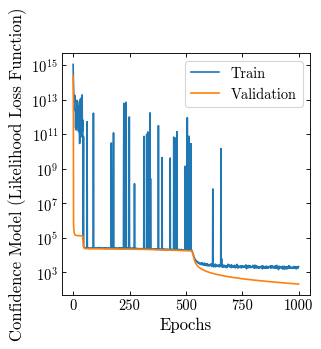

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Confidence Model (Likelihood Loss Function)')
plt.legend(['Train', 'Validation'])
plt.show()

In [38]:
CheckPoint3 = ModelCheckpoint('models/TrainingBoth_{epoch:04d}.hdf5',
                             verbose=0,
                             save_best_only=False
                            )
ES2 = EarlyStopping(patience=20, verbose=True, restore_best_weights=True)
RLR2 = ReduceLROnPlateau(patience=10, min_lr=1e-5)
CSV_logger3 = CSVLogger(filename='logs/training_both.log', separator=',', append=False)

mycallbacks3 = [CheckPoint3, ES2, RLR2, CSV_logger3]

In [39]:
ConfModel.trainable = True
MeanModel.trainable = True
CombinedModel.compile(loss=LikelihoodLossFunction,
                      optimizer='adam'
                     )

history = CombinedModel.fit(X_train,y_train,
                  validation_data=(X_val, y_val),
                  epochs=1000,
                  batch_size=10000,
                  callbacks = mycallbacks3,
                 )

Train on 31999 samples, validate on 7999 samples
Epoch 1/1000
31999/31999 [==============================] - 1s 33us/step - loss: 1700.3352 - val_loss: 169.9579
Epoch 2/1000
31999/31999 [==============================] - 0s 7us/step - loss: 1073.2759 - val_loss: 135.2969
Epoch 3/1000
31999/31999 [==============================] - 0s 7us/step - loss: 601.0735 - val_loss: 109.9918
Epoch 4/1000
31999/31999 [==============================] - 0s 7us/step - loss: 403.5265 - val_loss: 91.6115
Epoch 5/1000
31999/31999 [==============================] - 0s 7us/step - loss: 325.9238 - val_loss: 78.0594
Epoch 6/1000
31999/31999 [==============================] - 0s 7us/step - loss: 320.0445 - val_loss: 67.4647
Epoch 7/1000
31999/31999 [==============================] - 0s 7us/step - loss: 196.6408 - val_loss: 59.3505
Epoch 8/1000
31999/31999 [==============================] - 0s 7us/step - loss: 165.9422 - val_loss: 53.1590
Epoch 9/1000
31999/31999 [==============================] - 0s 7us/step -

In [ ]:
plot_model(CombinedModel, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

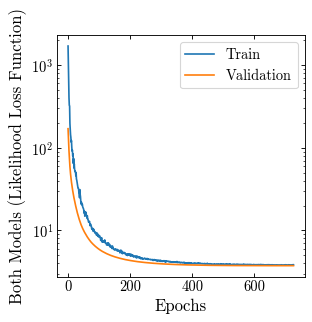

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Both Models (Likelihood Loss Function)')
plt.legend(['Train', 'Validation'])
plt.show()

In [159]:
def make_plots_trainmean(i):
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2,2,1)
    plt.hist(y_val[:,0], bins=50, range=(y_low,y_high), histtype='step', color= 'skyblue', fill = True, label = 'val' )
    plt.hist(test_preds[:,0], bins=50, range=(y_low,y_high), histtype='step',color = 'blue', label = 'predicted')
    plt.xlabel('Vr')
    plt.ylabel('Stars')
    plt.title('Validation set, Train Mean, Epoch '+ str(i))
    plt.yscale('log')
    plt.legend(loc = "upper right")
    
    
    plt.subplot(2,2,2)
    #sc = plt.scatter(y_val[:,0], test_preds[:,0], c =test_preds[:,1], label = 'data',marker = '.',cmap='jet')
    hb = plt.hexbin(y_val[:,0], test_preds[:,0],gridsize=75)
    x1 = np.linspace(y_low,y_high,1000)
    y1 = x1
    plt.plot(x1,y1,'k--')
    plt.xlim([y_low, y_high])
    plt.ylim([y_low,y_high])
    plt.ylabel('Vr predicted')
    plt.xlabel('Vr real')
    clb = plt.colorbar(hb, label = 'Number of Points')
    #plt.clim(0,y_high/2)
    plt.savefig('plots/trainmean_'+str(i)+'.png')
    clb.remove()
    
    

In [160]:
traininmean = [file for file in os.listdir('models/')
               if file.startswith('TrainingMean')]
traininmean = sorted(traininmean)[1:243]

In [161]:
%%capture
for i, mfile in enumerate(traininmean):
    CombinedModel.load_weights('models/' + mfile)
    
    test_preds = CombinedModel.predict(X_val)

    
    make_plots_trainmean(i);

In [162]:
def make_plots_trainerror(i):
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2,2,1)
    plt.hist(y_val[:,0], bins=50, range=(y_low,y_high), histtype='step', color= 'skyblue', fill = True, label = 'val' )
    plt.hist(test_preds[:,0], bins=50, range=(y_low,y_high), histtype='step',color = 'blue', label = 'predicted')
    plt.xlabel('Vr')
    plt.ylabel('Stars')
    plt.title('Validation set, Train Error, Epoch '+ str(i))
    plt.yscale('log')
    plt.legend(loc = "upper right")
    
    
    plt.subplot(2,2,2)
    sc = plt.scatter(y_val[:,0], test_preds[:,0], c =test_preds[:,1], label = 'data',marker = '.',cmap='jet')
    #hb = plt.hexbin(y_val[:,0], test_preds[:,0],gridsize=75)
    x1 = np.linspace(y_low,y_high,1000)
    y1 = x1
    plt.plot(x1,y1,'k--')
    plt.xlim([y_low, y_high])
    plt.ylim([y_low,y_high])
    plt.ylabel('Vr predicted')
    plt.xlabel('Vr real')
    clb = plt.colorbar(sc, label = 'Absolute Error Validation Set')
    plt.clim(0,1)
    plt.savefig('plots_error/trainerror_'+str(i)+'.png')
    clb.remove()

In [163]:
traininerror = [file for file in os.listdir('models/')
               if file.startswith('TrainingErrorBars')]
traininerror = sorted(traininerror)[:-20]

In [ ]:
%%capture
for i_err, mfile_err in enumerate(traininerror):
    CombinedModel.load_weights('models/' + mfile_err)
    
    test_preds = CombinedModel.predict(X_val)

    
    make_plots_trainerror(i_err);

In [151]:
print(np.max(test_preds[:,1]))

7.767224


In [152]:
def make_plots_trainboth(i):
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2,2,1)
    plt.hist(y_val[:,0], bins=50, range=(y_low,y_high), histtype='step', color= 'skyblue', fill = True, label = 'val' )
    plt.hist(test_preds[:,0], bins=50, range=(y_low,y_high), histtype='step',color = 'blue', label = 'predicted')
    plt.xlabel('Vr')
    plt.ylabel('Stars')
    plt.title('Validation set, Train Both, Epoch '+ str(i))
    plt.yscale('log')
    plt.legend(loc = "upper right")
    
    
    plt.subplot(2,2,2)
    sc = plt.scatter(y_val[:,0], test_preds[:,0], c =test_preds[:,1], label = 'data',marker = '.',cmap='jet')
    #hb = plt.hexbin(y_val[:,0], test_preds[:,0],gridsize=75)
    x1 = np.linspace(y_low,y_high,1000)
    y1 = x1
    plt.plot(x1,y1,'k--')
    plt.xlim([y_low, y_high])
    plt.ylim([y_low,y_high])
    plt.ylabel('Vr predicted')
    plt.xlabel('Vr real')
    clb = plt.colorbar(sc, label = 'Absolute Error Validation Set')
    plt.clim(0,y_high/2)
    plt.savefig('plots_both/trainboth_'+str(i)+'.png')
    clb.remove()

In [156]:
traininboth = [file for file in os.listdir('models/')
               if file.startswith('TrainingBoth')]
traininboth = sorted(traininboth)[1:380]


In [157]:
%%capture
for i_both, mfile_both in enumerate(traininboth):
    CombinedModel.load_weights('models/' + mfile_both)
    
    test_preds = CombinedModel.predict(X_val)

    
    make_plots_trainboth(i_both);

In [45]:
print(np.size(y_test))

10000


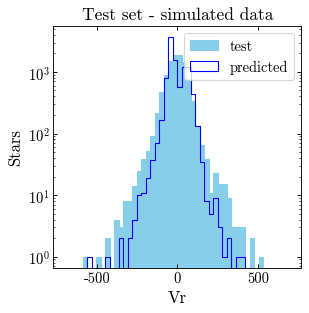

In [43]:
test_preds_2 = CombinedModel.predict(X_test)

plt.figure()
plt.hist(y_test, bins=50, range=(y_low,y_high), histtype='step', edgecolor = 'skyblue', color= 'skyblue', fill = True, label = 'test' )
plt.hist(test_preds_2[:,0], bins=50, range=(y_low,y_high), histtype='step',color = 'blue', label = 'predicted')
plt.xlabel('Vr')
plt.ylabel('Stars')
plt.title('Test set - simulated data')
plt.yscale('log')
plt.legend(loc = "upper right")
plt.show()

Going to use Monte Carlo simulations to predict errorbars. 

(2, 50)


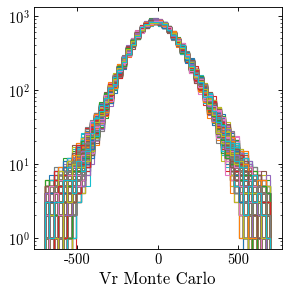

In [97]:
mc_vr_pred_list = []
bin_values_list = []
for mc_i in range(0,1000):
    mc_vr_pred = []
    for star_i in range(0,np.size(y_test)):
        mc_vr_pred.append(np.random.normal(test_preds_2[star_i,0],test_preds_2[star_i,1]))
    mc_vr_pred_list.append(mc_vr_pred)
    n, bins, patches = plt.hist(mc_vr_pred, bins=50, range=(y_low,y_high), histtype='step')
    plt.xlabel('Vr Monte Carlo')
    plt.yscale('log')
    bin_values_list.append(n)
bin_values_list_arr = np.array(bin_values_list)    
max_array = bin_values_list_arr.max(axis=0)
min_array = bin_values_list_arr.min(axis=0) 
mean_array = bin_values_list_arr.mean(axis=0)
y_error = [min_array,max_array]
print(np.shape(y_error))

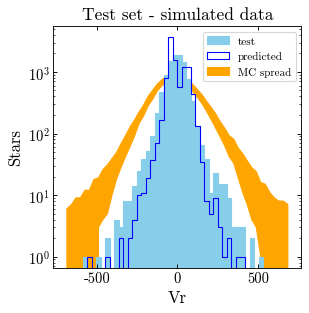

In [100]:
plt.figure()
hist_test, bins_test, patches_test = plt.hist(y_test, bins=50, range=(y_low,y_high), histtype='step', edgecolor = 'skyblue', color= 'skyblue', fill = True, label = 'test' )
#plt.hist(bins_test[:-1], bins_test, weights=max_array,color = 'green')
#plt.hist(bins_test[:-1], bins_test, weights=min_array,color = 'yellow')
bin_centers_test = (bins_test[1:]+bins_test[:-1])/2

plt.hist(test_preds_2[:,0], bins=50, range=(y_low,y_high), histtype='step',color = 'blue', label = 'predicted')
plt.fill_between(bin_centers_test,min_array, max_array,label = 'MC spread',color = 'orange')
plt.xlabel('Vr')
plt.ylabel('Stars')
plt.title('Test set - simulated data')
plt.yscale('log')
plt.legend(loc = "upper right",prop={'size': 10})
plt.show()

Text(0, 0.5, 'Error on Vr predicted')

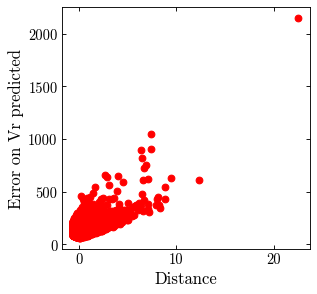

In [49]:
plt.scatter(X_test[:,2], test_preds_2[:,1], color = 'red')
#plt.errorbar(X_test[1:50,2], test_preds_2[1:50,0], yerr = test_preds_2[1:50,1], color = 'red',ls='none')
plt.xlabel('Distance')
plt.ylabel('Error on Vr predicted')
#does give a relu output...but I'm still not sure if this is exactly showing the error

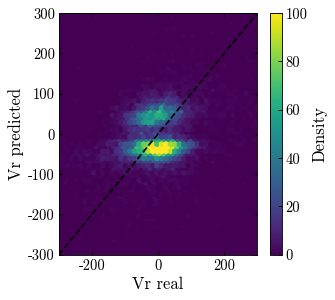

In [177]:
y_low = -300
y_high= 300
hb = plt.hexbin(y_test[:,0], test_preds_2[:,0],gridsize=80)
x1 = np.linspace(y_low,y_high,1000)
y1 = x1
plt.plot(x1,y1,'k--')
plt.xlim([y_low,y_high])
plt.ylim([y_low,y_high])
plt.ylabel('Vr predicted')
plt.xlabel('Vr real')
cb = plt.colorbar(hb,label = 'Density')
#clb = plt.colorbar(sc1, label = 'Absolute Error Test Set')
plt.clim(0,100)

In [178]:
np.max(test_preds_2[:,1])

104.45981

In [ ]:
#plt.errorbar(y_test, test_preds_2[:,0], yerr = test_preds_2[:,1], color = 'red',ls='none')
data_err1 = np.column_stack([y_test[:,0], test_preds_2[:,0],test_preds_2[:,1]])
print(data_err1.shape)
for gt in range(0,100,10): 
    fig = plt.figure(gt)
    data_err1 = data_err1[data_err1[:,2] > gt]
    print(data_err1.shape)
    sc = plt.scatter(data_err1[:,0], data_err1[:,1], c =data_err1[:,2], label = 'data',marker = '.',cmap='jet')
    #sc = plt.scatter(y_test, test_preds_2[:,0], c =test_preds_2[:,1], label = 'data',marker = '.',cmap=plt.cm.YlOrRd)
    x1 = np.linspace(y_low,y_high,1000)
    y1 = x1
    plt.plot(x1,y1,'k--')
    plt.xlim([y_low, y_high])
    plt.ylim([y_low,y_high])
    plt.ylabel('Vr predicted')
    plt.xlabel('Vr real')
    plt.title('All Points Error Greater Than '+str(gt))
    clb = plt.colorbar(sc, label = 'Absolute Error Test Set')
    plt.clim(0,10)
    plt.savefig('error_gt/error_greater_than_'+str(gt)+'.png')
    clb.remove()

Should also do a density plot for this one. Also plot loss function for second method (will need to include output for .fit). 

In [ ]:
#plt.errorbar(y_test, test_preds_2[:,0], yerr = test_preds_2[:,1], color = 'red',ls='none')
sc = plt.scatter(y_test[:,0], test_preds_2[:,0], c =(test_preds_2[:,1]/(y_test[:,0]+1e-6)), label = 'data',marker = '.',cmap=plt.cm.YlOrRd)
x1 = np.linspace(-200,200,1000)
y1 = x1
plt.plot(x1,y1,'k--')
plt.xlim([-200, 200])
plt.ylim([-200,200])
plt.ylabel('Vr predicted')
plt.xlabel('Vr real')
clb = plt.colorbar(sc, label = 'Fractional (error/ vr true)Error Test Set')
plt.clim(-5,5)